### Introduction

In this introductory tutorial for MLflow Custom Pyfunc, we will delve into the core features of the ``PythonModel`` class and explore how to use them to build a very simple model that can be saved, loaded, and used for inference.  

Objective: By the end of this guide, you will learn how to:

- Define a custom PyFunc model using Python classes.
- Understand the core components of the PyFunc flavor.
- Save, load, and predict using the custom PyFunc model.
- Leverage the power of MLflow's PyFunc for a real-world example: the Lissajous curve.

### The ``PythonModel`` class

MLflow's approach for generic model instance types takes a strict approach to standardization to ensure that any model that is stored with MLflow can be used for inference, provided that the implementation guidelines are adhered to. 

There are two ways in order to create a custom PythonModel instance. The first, which is what we are going to be using in this guide, involves defining a class and methods that will be used for the interface. There is another approach that can be used, which is to define a function named ``predict`` and logging that as the ``python_model`` argument in ``mlflow.pyfunc.save_model()``. This approach is more limited, but for implementations in which the entire logic of prediction can be encapsulated within a single function, it is preferrable. For this second mode of pyfunc logging, a generic PythonModel class will be created and logged for you with your provided ``predict`` function added as the ``predict()`` method within the class. 

#### Core PythonModel components

MLflow's PyFunc revolves around the PythonModel class. The two essential methods in this class are:
1. `load_context(self, context)`: This method is used to load artifacts or other initialization tasks. It is optional and can be used to fetch external references.
2. `predict(self, context, model_input, params=None)`: This is the entry point of your model when predictions are made. It must be defined for your custom PyFunc model.

For instance, if your model uses an external library like XGBoost, you can load the XGBoost model in the `load_context` method and use it in the `predict` method.

##### Basic Guidelines for a PythonModel 

The guidelines for this approach are as follows:

1. Your class must be a subclass of ``mlflow.pyfunc.PythonModel``
2. Your class must implement a ``predict`` method
3. The ``predict`` method must adhere to the requirements of the [Inference API](https://www.mlflow.org/docs/latest/python_api/mlflow.pyfunc.html#inference-api).
4. The predict method must have reference to ``context`` as the first named argument
5. If you wish to provide parameters with your model, these must be defined as part of the model signature. The signature must be saved along with the model. 
6. If you intend to have additional functionality execute when loading the model (such as loading additional dependent files), you may decide to define the ``load_context`` method in your class. 

### Define a simple Python Model
For this tutorial, we won't be covering the more advanced ``load_context`` or interfacing with the ``context`` argument within the ``predict`` method. We'll keep this simple for purposes of understanding the most basic aspects of a custom ``PythonModel``. 

For the purposes of showing additional usages of an MLflow custom Pyfunc model, we won't be looking at the typical library use cases. Instead, we'll take a look at using MLflow to store a configured instance of a Lissajous implementation. 

#### Lissajous curves
Originating from the field of harmonics, Lissajous curves are parametric sinusoidal curves defined by:

$$ x(t) = A \sin(a t + \delta) $$
$$ y(t) = B \sin(b t) $$

Where:

- \( $A$ \) and \( $B$ \) are the amplitudes of the curves along the x and y axes respectively.

- \( $a$ \) and \( $b$ \) determine the frequency of oscillations.

- \( $\delta$ \) is the phase difference between the x and y components.

We'll be creating  a simple model that will allow users to generate different patterns associated with the ratios of frequency oscillations and their phases. 

### Step 1: Define the Custom PyFunc Model

We begin by defining a Python class for our custom model. The class should inherit from `mlflow.pyfunc.PythonModel`.

In our Lissajous model, we initialize it with parameters \( $A$ \), \( $B$ \), and `num_points`. The `predict` method is responsible for plotting the Lissajous curve based on inputs \( $a$ \), \( $b$ \), and \( $\delta$ \).


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import mlflow.pyfunc
from mlflow.models import infer_signature


class Lissajous(mlflow.pyfunc.PythonModel):
    def __init__(self, A=1, B=1, num_points=1000):
        self.A = A
        self.B = B
        self.num_points = num_points
        self.t_range = (0, 2 * np.pi)

    def generate_lissajous(self, a, b, delta):
        t = np.linspace(self.t_range[0], self.t_range[1], self.num_points)
        x = self.A * np.sin(a * t + delta)
        y = self.B * np.sin(b * t)
        return pd.DataFrame({"x": x, "y": y})

    def predict(self, context, model_input, params=None):
        """
        Generate and plot the Lissajous curve with annotations for parameters.

        Args:
        - model_input (pd.DataFrame): DataFrame containing columns 'a' and 'b'.
        - params (dict, optional): Dictionary containing optional parameter 'delta'.
        """
        # Extract a and b values from the input DataFrame
        a = model_input["a"].iloc[0]
        b = model_input["b"].iloc[0]

        # Extract delta from params or set it to 0 if not provided
        delta = params.get("delta", 0)

        # Generate the Lissajous curve data
        df = self.generate_lissajous(a, b, delta)

        sns.set_theme()

        # Create the plot components
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.plot(df["x"], df["y"])
        ax.set_title("Lissajous Curve")

        # Define the annotation string
        annotation_text = f"""
        A = {self.A}
        B = {self.B}
        a = {a}
        b = {b}
        delta = {np.round(delta, 2)} rad
        """

        # Add the annotation with a bounding box outside the plot area
        ax.annotate(
            annotation_text,
            xy=(1.05, 0.5),
            xycoords="axes fraction",
            fontsize=12,
            bbox={"boxstyle": "round,pad=0.25", "facecolor": "aliceblue", "edgecolor": "black"},
        )

        # Adjust plot borders to make space for the annotation
        plt.subplots_adjust(right=0.65)
        plt.close()

        # Return the plot
        return fig

### Step 2: Save the Model

Once our model class is defined, we can instantiate it and save it using MLflow. The `infer_signature` method is useful here to automatically deduce the input and output schema for the model.

Because we are using `params` for overriding the `delta` value of the equation, we need to provide the signature of the model during saving. Failing to define this here means that usages of the loaded instance of this model (if saved without a signature) will ignore provided params (with a warning). 

In [2]:
# Define the path to save the model
model_path = "lissajous_model"

# Create an instance of the model, overriding the default instance variables `A`, `B`, and `num_points`
model_10k_standard = Lissajous(1, 1, 10_000)

# Infer the model signature, ensuring that we define the params that will be available for customization at inference time
signature = infer_signature(pd.DataFrame([{"a": 1, "b": 2}]), params={"delta": np.pi / 5})

# Save our custom model to the path we defined, with the signature that we declared
mlflow.pyfunc.save_model(path=model_path, python_model=model_10k_standard, signature=signature)

/Users/benjamin.wilson/miniconda3/envs/mlflow-dev-env/lib/python3.8/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None
/Users/benjamin.wilson/miniconda3/envs/mlflow-dev-env/lib/python3.8/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is re

### Step 3: Load the Model
After saving, we can load the model back and use it for predictions. Here, our prediction is the Lissajous curve plot.

In [3]:
# Load our custom model from the local artifact store
loaded_pyfunc_model = mlflow.pyfunc.load_model(model_path)

### Step 4: Use the model for generating curves

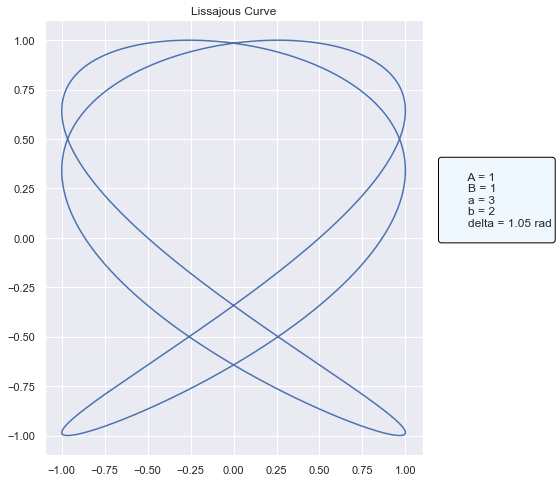

In [4]:
# Define the input DataFrame. In our custom model, we're reading only the first row of data to generate a plot.
model_input = pd.DataFrame({"a": [3], "b": [2]})

# Define a params override for the `delta` parameter
params = {"delta": np.pi / 3}

# Run predict, which will call our internal method `generate_lissajous` before generating a `matplotlib` plot showing the curve
fig = loaded_pyfunc_model.predict(model_input, params)

# Display the plot
fig

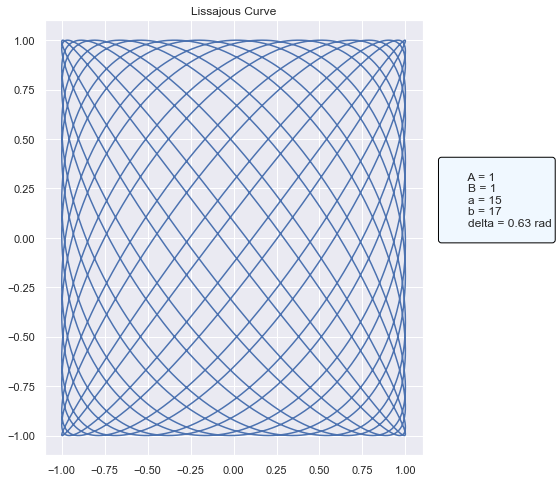

In [5]:
# Try a different configuration of arguments
fig2 = loaded_pyfunc_model.predict(
    pd.DataFrame({"a": [15], "b": [17]}), params={"delta": np.pi / 5}
)

fig2